In [77]:
%pylab inline
from astropy.io import fits
import glob
import pandas as pd
from pandas import DataFrame
from scipy.interpolate import interp1d
from nirspec import gluespec #,divspec
from spec_utils import vgeo#, vlsr_to_vehelio
import pdb as pdb
import astropy
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astroquery.hitran import Hitran
from flux_calculator import extract_hitran_data, calc_fluxes, extract_vup, make_rotation_diagram
import numpy
from slabspec import extract_hitran_data


Populating the interactive namespace from numpy and matplotlib


In [78]:
#12/13/2010 & 12/14/2010
hdulist20101213 = fits.open('/Users/hanna/Desktop/URSI/ABAUR_20101213_glue.fits')
data20101213 = hdulist20101213[1].data
#12/31/2012,01/01/2013 & 01/03/2013
hdulist20121231 = fits.open('/Users/hanna/Desktop/URSI/ABAUR_20130103_glue.fits')
data20121231 = hdulist20121231[1].data
#12/23/2013 & 12/24/2013
hdulist20131223 = fits.open('/Users/hanna/Desktop/URSI/ABAUR_20131223_glue.fits')
data20131223 = hdulist20131223[1].data

In [79]:
#Telluric Cutoff
no = 0.60
from astropy.table import Table
t = Table.read('/Users/hanna/Desktop/URSI/ABAUR_20101213_glue.fits')
df1213 = t.to_pandas()
df1213 = DataFrame(df1213, columns = ['wave', 'div', 'src', 'std'])
df1213.loc[df1213['std'] >0, 'std'] = (df1213['std']/1.302589514146253) #normalize
df1213.loc[df1213['std'] <no, 'div'] = None

t = Table.read('/Users/hanna/Desktop/URSI/ABAUR_20130103_glue.fits')
df1231 = t.to_pandas()
df1231 = DataFrame(df1231, columns = ['wave', 'div', 'src', 'std'])
df1231.loc[df1231['std'] >0, 'std'] = (df1231['std']/1.3036475482894394) #normalize
df1231.loc[df1231['std'] <no, 'div'] = None

t = Table.read('/Users/hanna/Desktop/URSI/ABAUR_20131223_glue.fits')
df1223 = t.to_pandas()
df1223 = DataFrame(df1223, columns = ['wave', 'div', 'src', 'std'])
df1223.loc[df1223['std'] >0, 'std'] = (df1223['std']/1.2383725618468646) #normalize
df1223.loc[df1223['std'] <no, 'div'] = None


**Doppler Shift Equation:**
$\Delta$$\lambda$ = $\lambda$*(1+v/c)

In [80]:
#I haven't pulled the update yet, I have to re-initiate git after I moved the data out of my local repository
def vproj(mycoord):
    vlsr=20.0*np.array([0.014498, -0.865863, 0.500071])  
    ra_rad=mycoord.ra.radian
    dec_rad=mycoord.dec.radian
    vproj = vlsr[0]*np.cos(dec_rad)*np.cos(ra_rad) + vlsr[1]*np.cos(dec_rad)*np.sin(ra_rad) + vlsr[2]*np.sin(dec_rad)
    return vproj
def vlsr_to_vhelio(mycoord, myvlsr):
    myvproj=vproj(mycoord)
    myvhelio=myvlsr-myvproj
    return myvhelio

In [81]:
#Doppler Shift
c = 3*10**5 #km/s

mydate1213=Time('2010-12-13T00:00:00.0', format='isot', scale='utc') #I used a program called Stellarium to look up the RA and DEC on the date of the observation
mydate1231=Time('2012-12-31T00:00:00.0', format='isot', scale='utc')
mydate1223=Time('2013-12-23T00:00:00.0', format='isot', scale='utc')

mycoord=SkyCoord('4h55m45.85s', '+30d33m04.29s', frame='icrs')
#mycoord1231=SkyCoord('4h56m34.65s', '+30d34m08.3s', frame='icrs')
#mycoord1223=SkyCoord('4h56m38.77s', '+30d34m12.0s', frame='icrs')

vhelio = vlsr_to_vhelio(mycoord, 5.9) #source in evernote

#Calculate the heliocentric velocity (Earth-induced + intrinsic)
myv1213=vgeo(mydate1213, mycoord, vhelio)
myv1231=vgeo(mydate1231, mycoord, vhelio)
myv1223=vgeo(mydate1223, mycoord, vhelio)

print(myv1213)
print(myv1231)
print(myv1223)

df1213.loc[df1213['wave']> 0, 'wave'] = (df1213['wave']*(1-myv1213/c)) #this is how I applied the doppler shift to each point in the data set
df1231.loc[df1231['wave']> 0, 'wave'] = (df1231['wave']*(1-myv1231/c)) 
df1223.loc[df1223['wave']> 0, 'wave'] = (df1223['wave']*(1-myv1223/c))

17.690010834928266
27.0314826710633
22.94258462486839


In [82]:
df1213.loc[df1213['wave']> 0, 'wave'] = (df1213['wave']+0.00035)

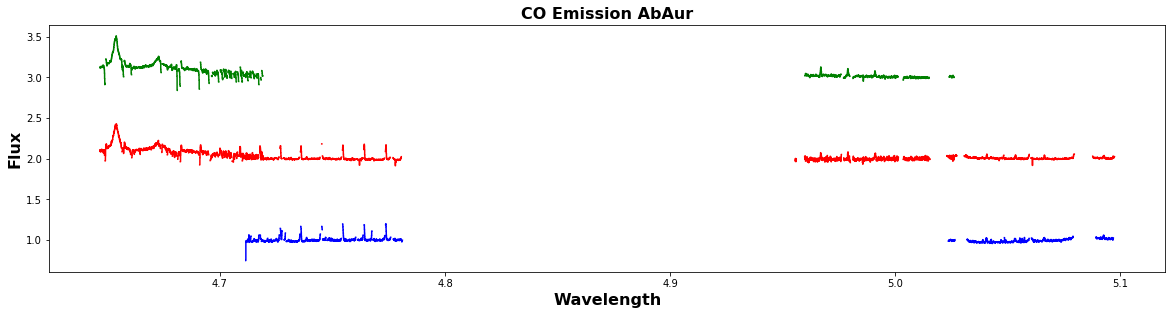

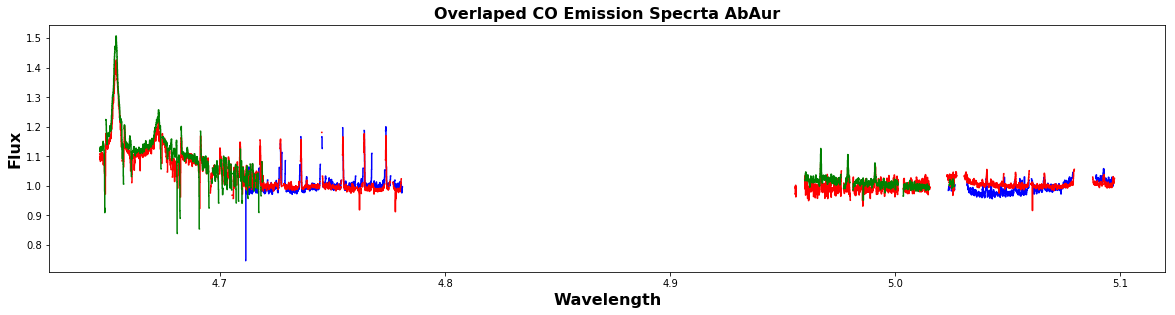

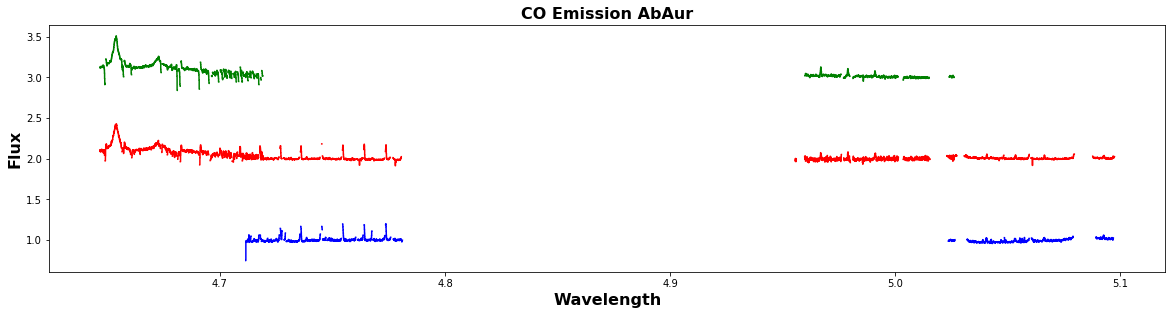

In [83]:
#Full Spectrum Over View Plot
#Attempting to upload indicies to the plots to make the emission lines easier to find
'''
out_all=extract_hitran_data('CO',4.6,5.2)  #astropy table
lineflux_data=extract_vup(out_all,1)
HitCO = lineflux_data['wave']

for xc in HitCO:
    axa.vlines(x=xc, ymin=ymin, ymax=ymax, color='purple', linestyle='--')
    axb.vlines(x=xc, ymin=ymin, ymax=ymax, color='purple', linestyle='--')
axb.legend()
'''
fig = plt.figure(figsize(20,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

ax1.set_title('CO Emission AbAur', fontsize=16, fontweight='bold')
ax1.set_xlabel('Wavelength', fontsize=16, fontweight='bold')
ax1.set_ylabel('Flux', fontsize=16, fontweight='bold')

ax1.plot(df1213['wave'],df1213['div']+0,linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div']+1,linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div']+2,linestyle='steps-mid', color = 'green')

fig =plt.figure(figsize(20,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

ax1.set_title('Overlaped CO Emission Specrta AbAur', fontsize=16, fontweight='bold')
ax1.set_xlabel('Wavelength', fontsize=16, fontweight='bold')
ax1.set_ylabel('Flux', fontsize=16, fontweight='bold')

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')

fig = plt.figure(figsize(20,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

ax1.set_title('CO Emission AbAur', fontsize=16, fontweight='bold')
ax1.set_xlabel('Wavelength', fontsize=16, fontweight='bold')
ax1.set_ylabel('Flux', fontsize=16, fontweight='bold')

ax1.plot(df1213['wave'],df1213['div']+0,linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div']+1,linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div']+2,linestyle='steps-mid', color = 'green')



<Figure size 1440x720 with 0 Axes>

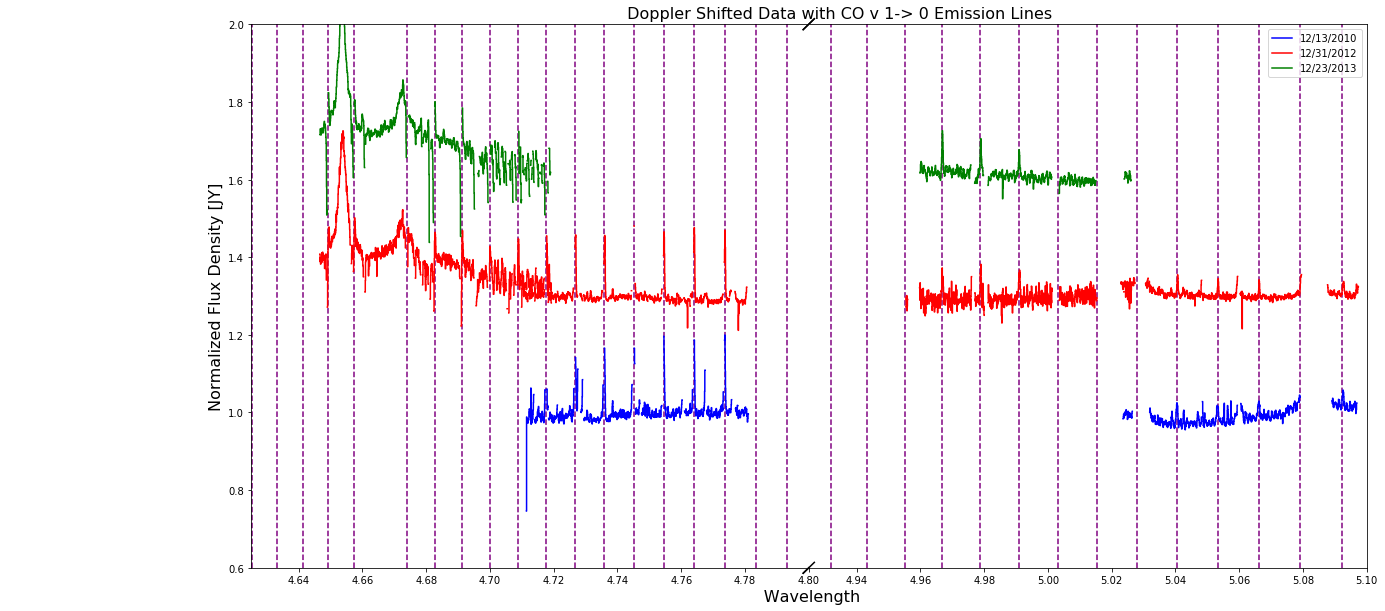

In [151]:
out_all=extract_hitran_data('CO',4.6,5.2)  #astropy table
lineflux_data=extract_vup(out_all,1)
HitCO = lineflux_data['wave']
#print(HitCO)

plt.figure(figsize(20,10))
axa = fig.add_subplot(211)
axb = fig.add_subplot(211)

f, (axa, axb) = plt.subplots(1, 2,sharex=False, sharey=True)
plt.subplots_adjust(wspace=0) #set to zero, if you want to join the two plots

axa.set_title('                                                                                                                         Doppler Shifted Data with CO v 1-> 0 Emission Lines', fontsize=16)
axa.set_xlabel('                                                                                                              Wavelength', fontsize=16)
axa.set_ylabel('Normalized Flux Density [JY]', fontsize=16)

axa.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
axb.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue', label = '12/13/2010')
axa.plot(df1231['wave'],df1231['div']+0.3,linestyle='steps-mid', color = 'red')
axb.plot(df1231['wave'],df1231['div']+0.3,linestyle='steps-mid', color = 'red', label = '12/31/2012')
axa.plot(df1223['wave'],df1223['div']+0.6,linestyle='steps-mid', color = 'green')
axb.plot(df1223['wave'],df1223['div']+0.6,linestyle='steps-mid', color = 'green', label = '12/23/2013')

ymin = 0.6
ymax = 2
plt.ylim(ymin,ymax)
axa.set_xlim(4.625, 4.8)
axb.set_xlim(4.925, 5.1)

axa.spines['right'].set_visible(False)
axb.spines['left'].set_visible(False)
axb.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

d=0.010
kwargs = dict(transform=axa.transAxes, color='k', clip_on=False)
axa.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
axa.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
kwargs.update(transform=axb.transAxes)  # switch to the bottom axes
axb.plot((-d, +d), (-d, +d), **kwargs)  # bottom-left diagonal
axb.plot((-d, +d), (1 - d, 1 + d), **kwargs)

for xc in HitCO:
    axa.vlines(x=xc, ymin=ymin, ymax=ymax, color='purple', linestyle='--')
    axb.vlines(x=xc, ymin=ymin, ymax=ymax, color='purple', linestyle='--')
    #print(xc)
axb.legend()

plt.show()


Text(0, 0.5, 'Flux')

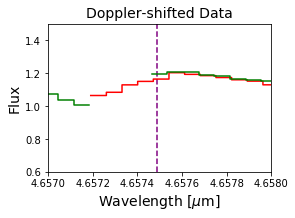

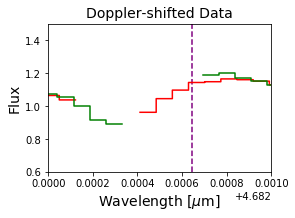

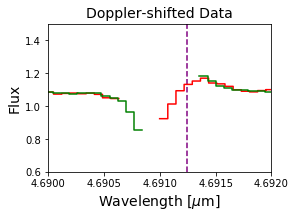

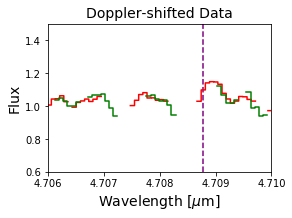

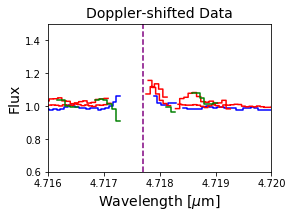

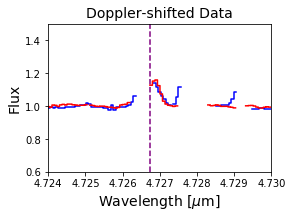

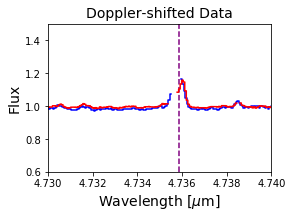

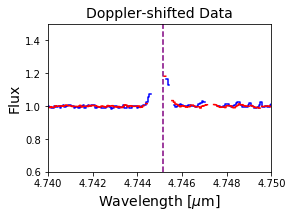

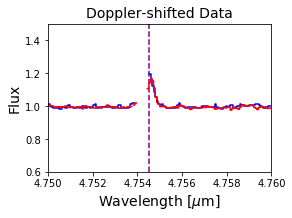

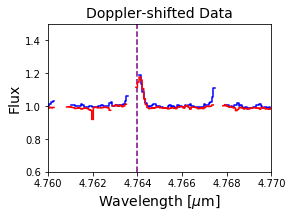

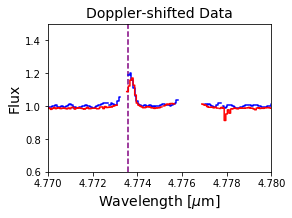

In [154]:
#Individual Line Profiles
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

left = 4.657
right = 4.658

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')
ax3.vlines(4.657486, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux', fontsize=14)

#Emission Line 3
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

left = 4.682
right = 4.683

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')
ax3.vlines(4.682643, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux', fontsize=14)

#Emission Line 4
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

left = 4.690
right = 4.692

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')
ax3.vlines(4.691242, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux', fontsize=14)

#Emission Line 4
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

left = 4.706
right = 4.71

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')
ax3.vlines(4.708766, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux', fontsize=14)

#Emission Line 4
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

left = 4.716
right = 4.72

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')
ax3.vlines(4.7176914, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux', fontsize=14)

#Emission Line 4
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

left = 4.724
right = 4.730

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')
ax3.vlines(4.726727, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux', fontsize=14)

#Emission Line 4
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

left = 4.73
right = 4.74

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')
ax3.vlines(4.735873, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux', fontsize=14)

#Emission Line 4
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

left = 4.74
right = 4.75

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')
ax3.vlines(4.745131, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux', fontsize=14)

#Emission Line 4
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

left = 4.75
right = 4.76

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')
ax3.vlines(4.754502, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux', fontsize=14)

#Emission Line 4
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

left = 4.76
right = 4.77

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')
ax3.vlines(4.7639856, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux', fontsize=14)

#Emission Line 4
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

left = 4.77
right = 4.78

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')
ax3.vlines(4.7735834, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux', fontsize=14)

Text(0, 0.5, 'Flux')

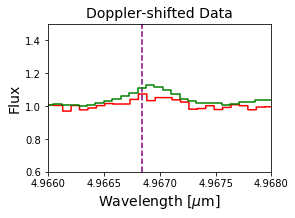

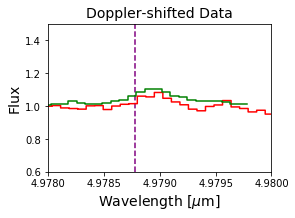

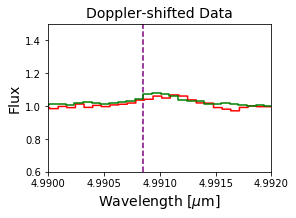

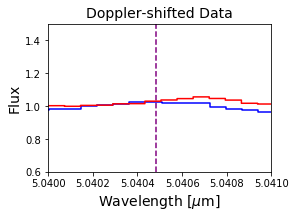

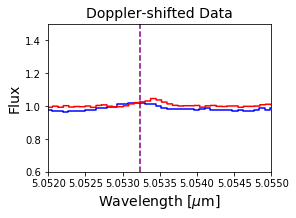

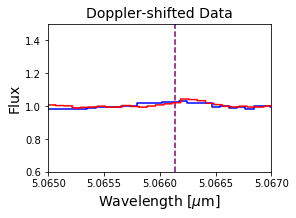

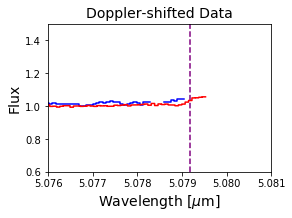

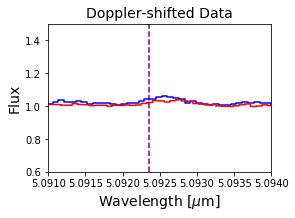

In [150]:
#Emission Line 4
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

left = 4.966
right = 4.968

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')
ax3.vlines(4.9668403, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux', fontsize=14)

#Emission Line 4
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

left = 4.978
right = 4.980

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')
ax3.vlines(4.978777, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux', fontsize=14)

#Emission Line 4
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

left = 4.990
right = 4.992

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')
ax3.vlines(4.9908466, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux', fontsize=14)

#Emission Line 4
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

left = 5.04
right = 5.041

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')
ax3.vlines(5.0404844, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux', fontsize=14)

#Emission Line 4
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

left = 5.052
right = 5.055

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')
ax3.vlines(5.0532393, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux', fontsize=14)

#Emission Line 4
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

left = 5.065
right = 5.067

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')
ax3.vlines(5.0661345, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux', fontsize=14)

#Emission Line 4
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

left = 5.076
right = 5.081

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')
ax3.vlines(5.079172, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux', fontsize=14)

#Emission Line 4
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

left = 5.091
right = 5.094

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')
ax3.vlines(5.092353, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux', fontsize=14)


<Figure size 1440x720 with 0 Axes>

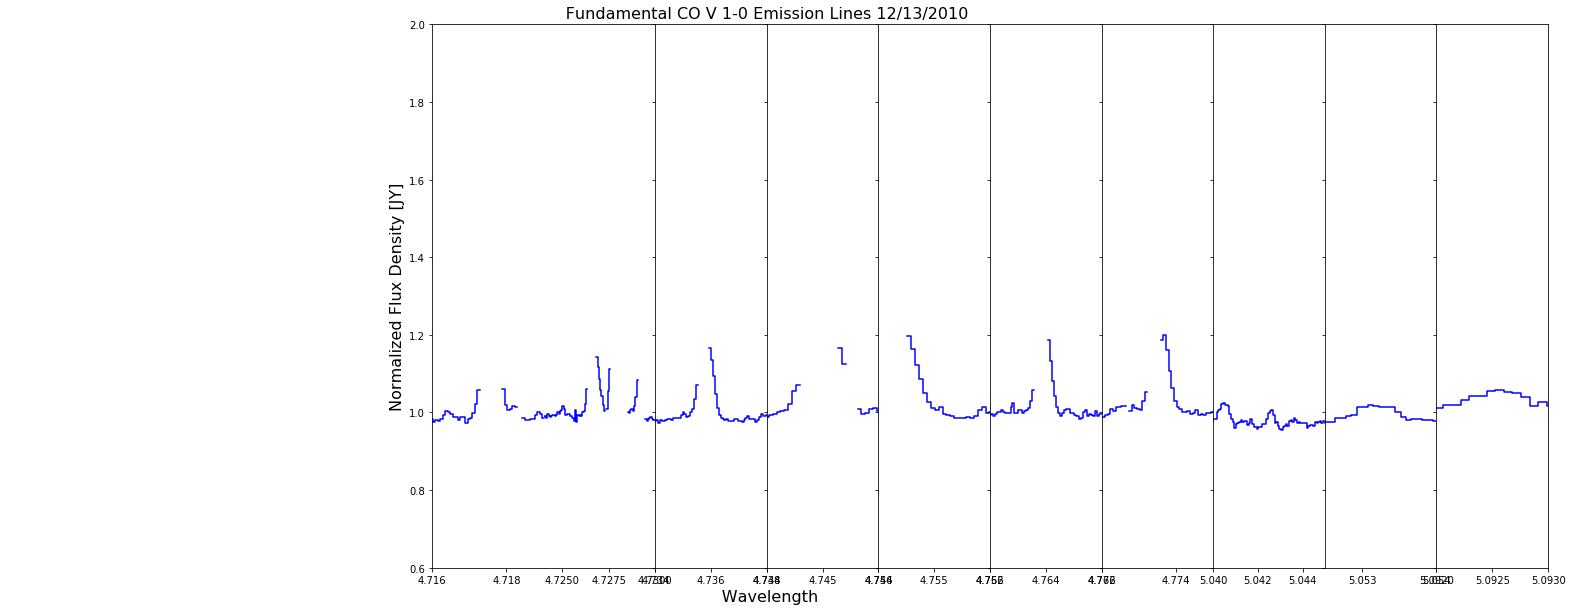

In [158]:
#Consecutive Emission Line Plot For 12/13/2010 have each emission line be a new axis and split the x axis by that amount?
out_all=extract_hitran_data('CO',4.6,5.2)  #astropy table
lineflux_data=extract_vup(out_all,1)
HitCO = lineflux_data['wave']
#print(HitCO)

plt.figure(figsize(20,10))
axa = fig.add_subplot(211)
axb = fig.add_subplot(211)

f, (axa, axb, axc, axd, axe, axf, axg, axh, axi, axj) = plt.subplots(1, 10,sharex=False, sharey=True)
plt.subplots_adjust(wspace=0) #set to zero, if you want to join the two plots

axa.set_title('                                                                                                             Fundamental CO V 1-0 Emission Lines 12/13/2010', fontsize=16)
axa.set_xlabel('                                                                                                              Wavelength', fontsize=16)
axa.set_ylabel('Normalized Flux Density [JY]', fontsize=16)

axa.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
axb.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue', label = '12/13/2010')
axc.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue', label = '12/13/2010')
axd.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue', label = '12/13/2010')
axe.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue', label = '12/13/2010')
axf.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue', label = '12/13/2010')
axg.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue', label = '12/13/2010')
axh.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue', label = '12/13/2010')
axi.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue', label = '12/13/2010')
axj.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue', label = '12/13/2010')


ymin = 0.6
ymax = 2
plt.ylim(ymin,ymax)
axa.set_xlim(4.716, 4.719)
axb.set_xlim(4.724, 4.730)
axc.set_xlim(4.734, 4.738)
axd.set_xlim(4.744, 4.746)
axe.set_xlim(4.754, 4.756)
axf.set_xlim(4.762, 4.766)
axg.set_xlim(4.772, 4.775)
axh.set_xlim(5.04, 5.045)
axi.set_xlim(5.0525, 5.0540)
axj.set_xlim(5.092,5.093)


axa.spines['right'].set_visible(False)
axb.spines['left'].set_visible(False)
axb.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

plt.show()


<Figure size 1440x720 with 0 Axes>

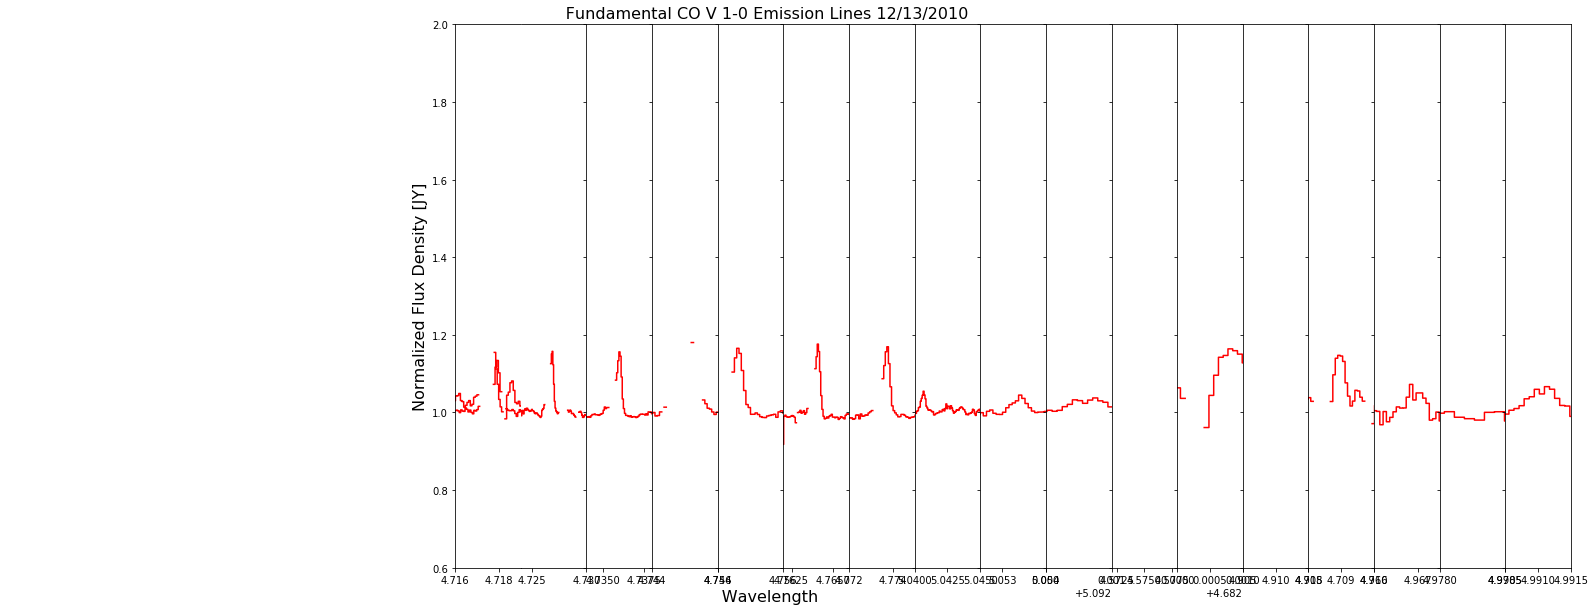

In [160]:
#Consecutive Emission Line Plot For 12/13/2010 have each emission line be a new axis and split the x axis by that amount?
out_all=extract_hitran_data('CO',4.6,5.2)  #astropy table
lineflux_data=extract_vup(out_all,1)
HitCO = lineflux_data['wave']
#print(HitCO)

plt.figure(figsize(20,10))
axa = fig.add_subplot(211)
axb = fig.add_subplot(211)

f, (axa, axb, axc, axd, axe, axf, axg, axh, axi, axj, axk, axl, axm, axn, axo, axp, axq) = plt.subplots(1, 17,sharex=False, sharey=True)
plt.subplots_adjust(wspace=0) #set to zero, if you want to join the two plots

axa.set_title('                                                                                                             Fundamental CO V 1-0 Emission Lines 12/13/2010', fontsize=16)
axa.set_xlabel('                                                                                                              Wavelength', fontsize=16)
axa.set_ylabel('Normalized Flux Density [JY]', fontsize=16)

axa.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
axb.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red', label = '12/31/2012')
axc.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red', label = '12/31/2012')
axd.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red', label = '12/31/2012')
axe.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red', label = '12/31/2012')
axf.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red', label = '12/31/2012')
axg.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red', label = '12/31/2012')
axh.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red', label = '12/31/2012')
axi.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red', label = '12/31/2012')
axj.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red', label = '12/31/2012')
axk.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red', label = '12/31/2012')
axl.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red', label = '12/31/2012')
axm.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red', label = '12/31/2012')
axn.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red', label = '12/31/2012')
axo.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red', label = '12/31/2012')
axp.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red', label = '12/31/2012')
axq.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red', label = '12/31/2012')

ymin = 0.6
ymax = 2
plt.ylim(ymin,ymax)
axa.set_xlim(4.716, 4.719)
axb.set_xlim(4.724, 4.730)
axc.set_xlim(4.734, 4.738)
axd.set_xlim(4.744, 4.746)
axe.set_xlim(4.754, 4.756)
axf.set_xlim(4.762, 4.766)
axg.set_xlim(4.772, 4.775)
axh.set_xlim(5.04, 5.045)
axi.set_xlim(5.0525, 5.0540)
axj.set_xlim(5.092,5.093)
axk.set_xlim(4.572,4.578)
axl.set_xlim(4.682,4.683)
axm.set_xlim(4.905,4.915)
axn.set_xlim(4.708,4.710)
axo.set_xlim(4.9660,4.9675)
axp.set_xlim(4.9780,4.9785)
axq.set_xlim(4.9905,4.9915)

axa.spines['right'].set_visible(False)
axb.spines['left'].set_visible(False)
axb.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

plt.show()


<Figure size 1440x720 with 0 Axes>

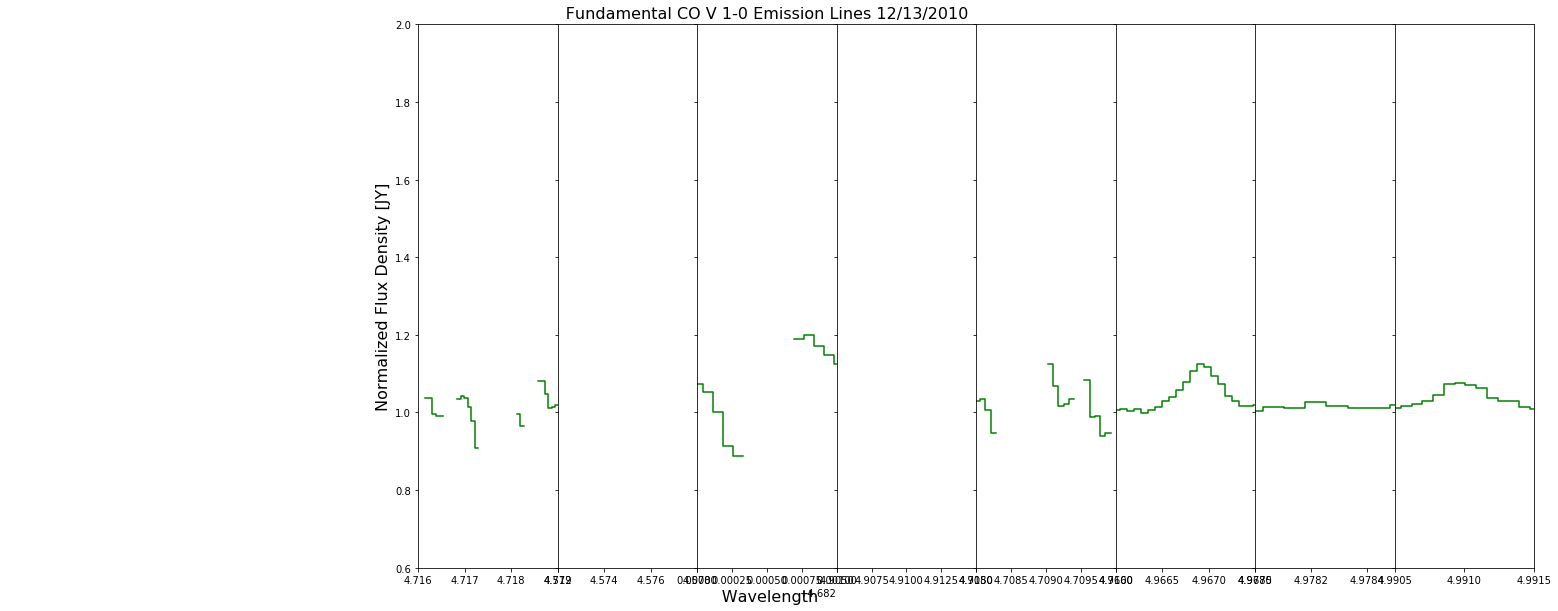

In [161]:
#Remember overlap emission line for green
#Consecutive Emission Line Plot For 12/13/2010 have each emission line be a new axis and split the x axis by that amount?
out_all=extract_hitran_data('CO',4.6,5.2)  #astropy table
lineflux_data=extract_vup(out_all,1)
HitCO = lineflux_data['wave']
#print(HitCO)

plt.figure(figsize(20,10))
axa = fig.add_subplot(211)
axb = fig.add_subplot(211)

f, (axa, axk, axl, axm, axn, axo, axp, axq) = plt.subplots(1, 8,sharex=False, sharey=True)
plt.subplots_adjust(wspace=0) #set to zero, if you want to join the two plots

axa.set_title('                                                                                                             Fundamental CO V 1-0 Emission Lines 12/13/2010', fontsize=16)
axa.set_xlabel('                                                                                                              Wavelength', fontsize=16)
axa.set_ylabel('Normalized Flux Density [JY]', fontsize=16)

axa.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')
axk.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green', label = '12/23/2013')
axl.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green', label = '12/23/2013')
axm.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green', label = '12/23/2013')
axn.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green', label = '12/23/2013')
axo.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green', label = '12/23/2013')
axp.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green', label = '12/23/2013')
axq.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green', label = '12/23/2013')

ymin = 0.6
ymax = 2
plt.ylim(ymin,ymax)
axa.set_xlim(4.716, 4.719)
axk.set_xlim(4.572,4.578)
axl.set_xlim(4.682,4.683)
axm.set_xlim(4.905,4.915)
axn.set_xlim(4.708,4.710)
axo.set_xlim(4.9660,4.9675)
axp.set_xlim(4.9780,4.9785)
axq.set_xlim(4.9905,4.9915)

axa.spines['right'].set_visible(False)
axb.spines['left'].set_visible(False)
axb.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

plt.show()


In [ ]:
#Let's examine line shape a little more closely and figure out why the emissionline data decreses w time and w wavelength - distance?




**Line Profiles**

Not enough data near  5.18900606925888  microns. Skipping.
Not enough data near  5.174782735717755  microns. Skipping.
Not enough data near  5.160712474562946  microns. Skipping.
Not enough data near  5.146793855211405  microns. Skipping.
Not enough data near  5.133025447080083  microns. Skipping.
Not enough data near  5.11940581958593  microns. Skipping.
Not enough data near  5.105934019006913  microns. Skipping.


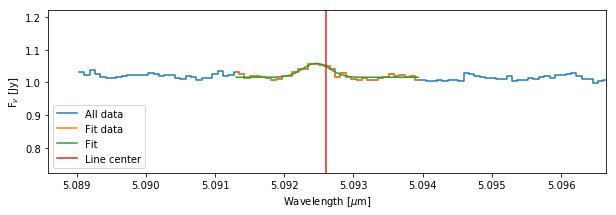

C:\Users\hanna\Anaconda\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


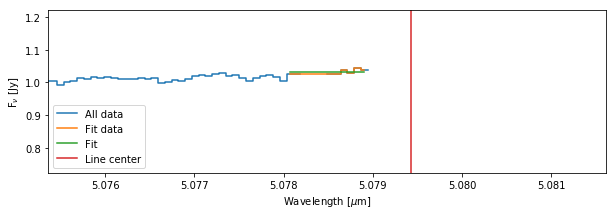

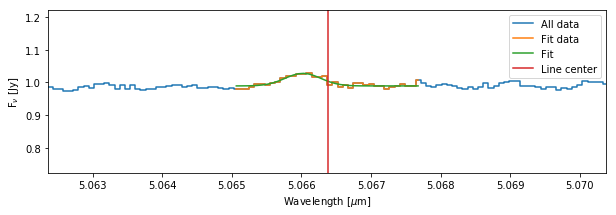

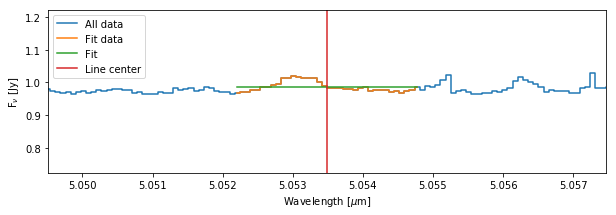

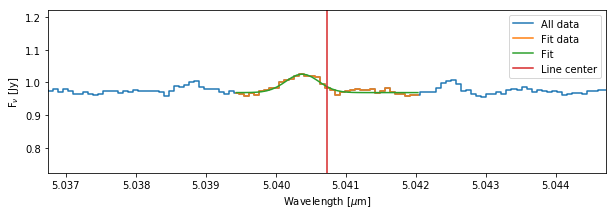

Not enough data near  5.028120792045639  microns. Skipping.
Not enough data near  5.015642769825146  microns. Skipping.
Not enough data near  5.003301606716407  microns. Skipping.
Not enough data near  4.99109634899739  microns. Skipping.
Not enough data near  4.979026042946061  microns. Skipping.
Not enough data near  4.9670887811183535  microns. Skipping.
Not enough data near  4.955284086653252  microns. Skipping.
Not enough data near  4.94361005210669  microns. Skipping.
Not enough data near  4.93206620061765  microns. Skipping.
Not enough data near  4.9206515784641  microns. Skipping.
Not enough data near  4.90936475506299  microns. Skipping.
Not enough data near  4.898204776692286  microns. Skipping.
Not enough data near  4.887170689629956  microns. Skipping.
Not enough data near  4.87626106329295  microns. Skipping.
Not enough data near  4.865475420820251  microns. Skipping.
Not enough data near  4.854812808489826  microns. Skipping.
Not enough data near  4.844271795718625  micro

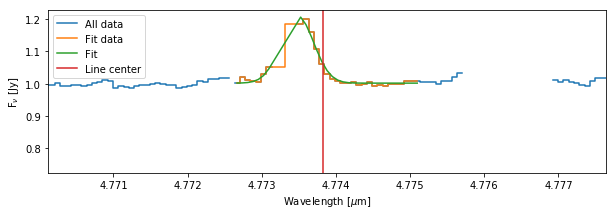

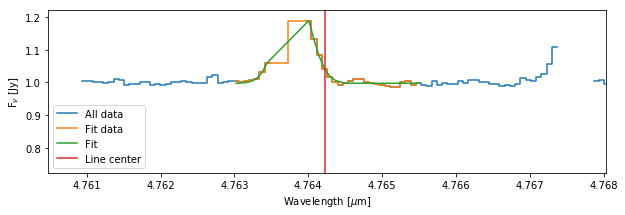

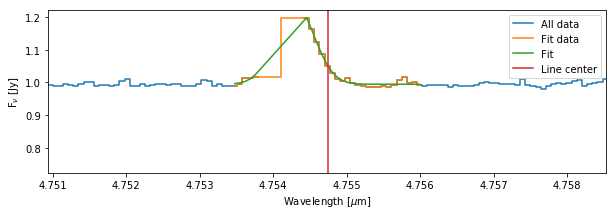

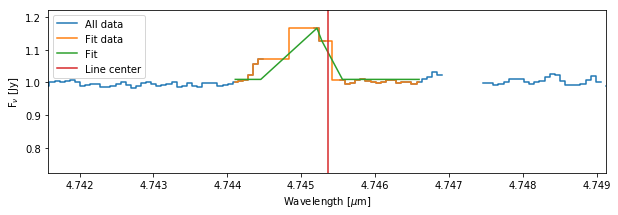

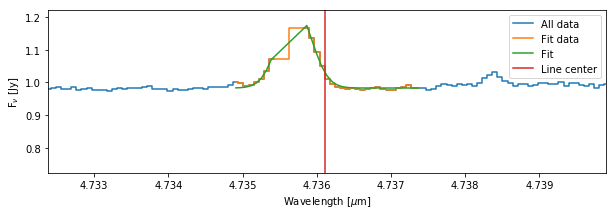

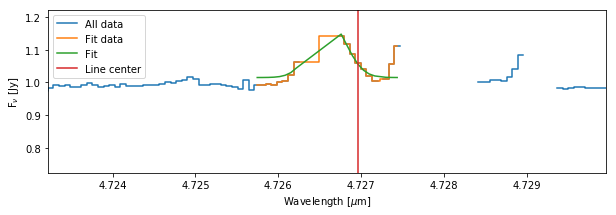

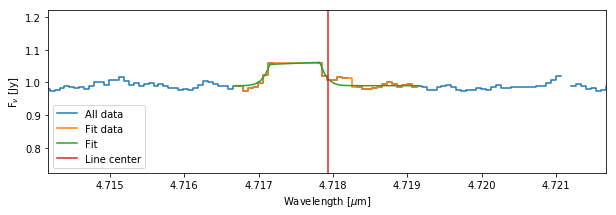

Not enough data near  4.709001584871265  microns. Skipping.
Not enough data near  4.700184901535969  microns. Skipping.
Not enough data near  4.691476942512449  microns. Skipping.
Not enough data near  4.682877230939691  microns. Skipping.
Not enough data near  4.674384813095659  microns. Skipping.
Not enough data near  4.65771899742768  microns. Skipping.
Not enough data near  4.649544645881699  microns. Skipping.
Not enough data near  4.641474250037329  microns. Skipping.
Not enough data near  4.633508286755587  microns. Skipping.
Not enough data near  4.625646279175457  microns. Skipping.
Not enough data near  4.617886796713888  microns. Skipping.
Not enough data near  4.610229362509864  microns. Skipping.
Not enough data near  4.602673976563386  microns. Skipping.


In [66]:
#Read in HITRAN data
out_all=extract_hitran_data('CO',4.6,5.2)  #astropy table
lineflux_data=extract_vup(out_all,1)

#For Data2010121314
wave=df1213['wave']
flux=df1213['div']
out=calc_fluxes(wave,flux,lineflux_data,fwhm_v=17., sep_v=80., cont=1.12,vet_fits=False, plot=True, v_dop=15.)

rot1213=make_rotation_diagram(out)

Not enough data near  5.18900606925888  microns. Skipping.
Not enough data near  5.174782735717755  microns. Skipping.
Not enough data near  5.160712474562946  microns. Skipping.
Not enough data near  5.146793855211405  microns. Skipping.
Not enough data near  5.133025447080083  microns. Skipping.
Not enough data near  5.11940581958593  microns. Skipping.
Not enough data near  5.105934019006913  microns. Skipping.


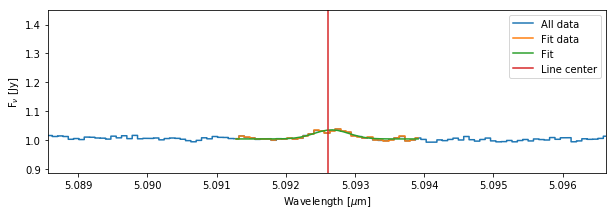

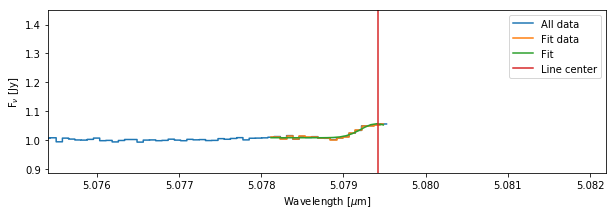

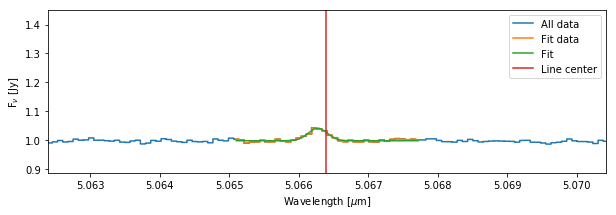

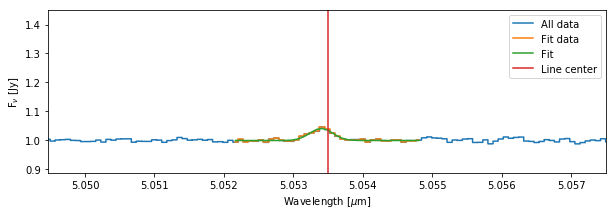

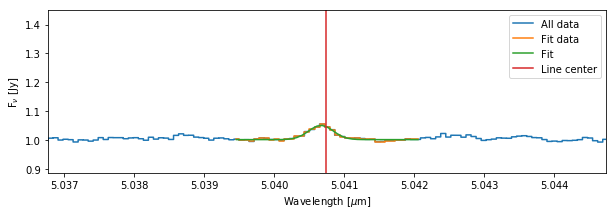

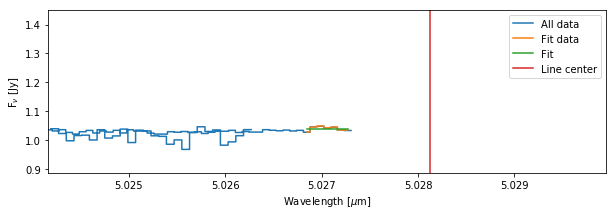

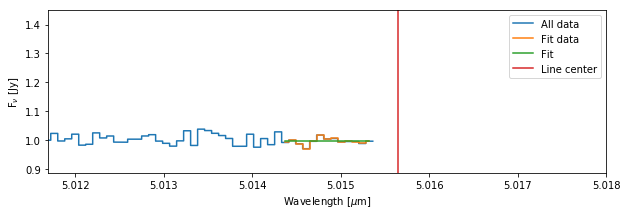

Error - curve_fit failed


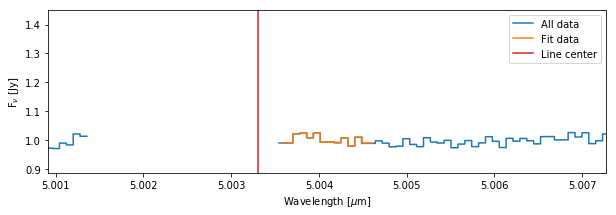

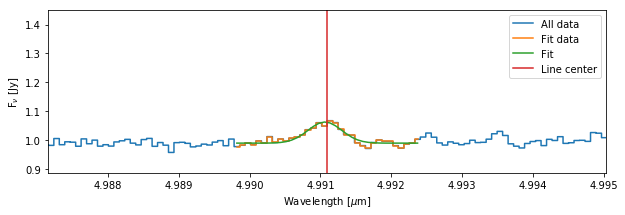

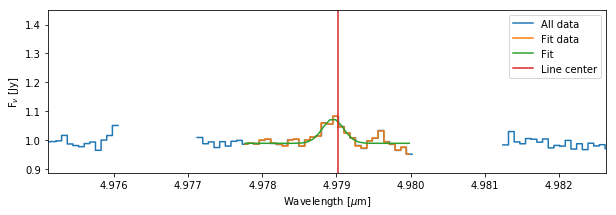

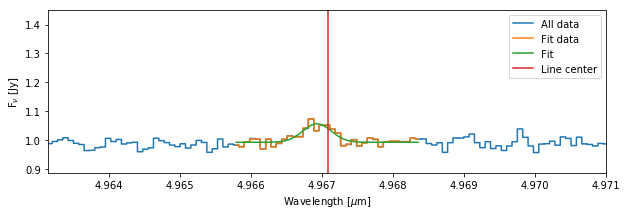

Error - curve_fit failed


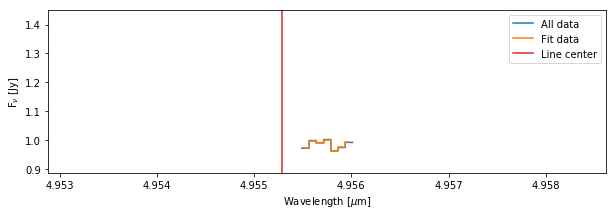

Not enough data near  4.94361005210669  microns. Skipping.
Not enough data near  4.93206620061765  microns. Skipping.
Not enough data near  4.9206515784641  microns. Skipping.
Not enough data near  4.90936475506299  microns. Skipping.
Not enough data near  4.898204776692286  microns. Skipping.
Not enough data near  4.887170689629956  microns. Skipping.
Not enough data near  4.87626106329295  microns. Skipping.
Not enough data near  4.865475420820251  microns. Skipping.
Not enough data near  4.854812808489826  microns. Skipping.
Not enough data near  4.844271795718625  microns. Skipping.
Not enough data near  4.833852382506649  microns. Skipping.
Not enough data near  4.823552184548815  microns. Skipping.
Not enough data near  4.8133716787061385  microns. Skipping.
Not enough data near  4.803309434395571  microns. Skipping.
Not enough data near  4.793363544173045  microns. Skipping.
Not enough data near  4.783535438621612  microns. Skipping.


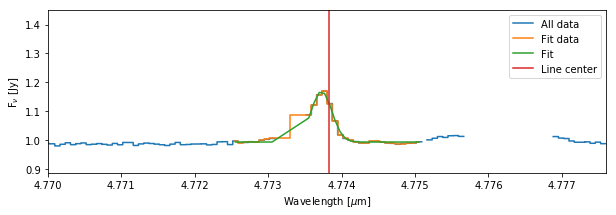

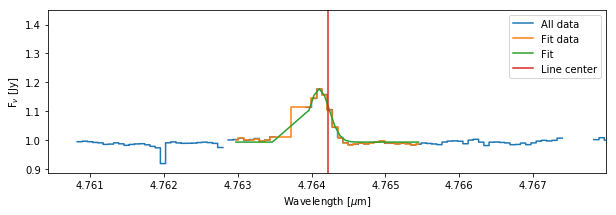

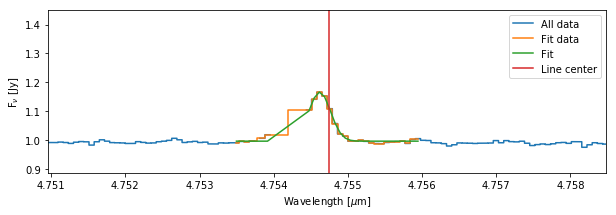

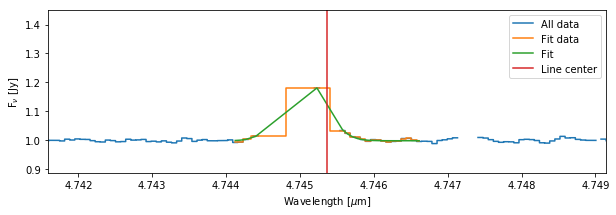

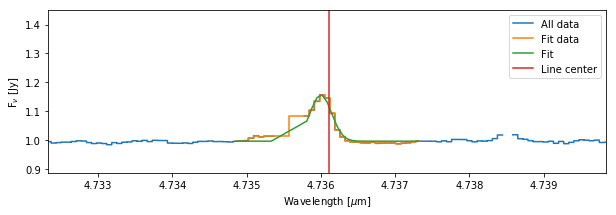

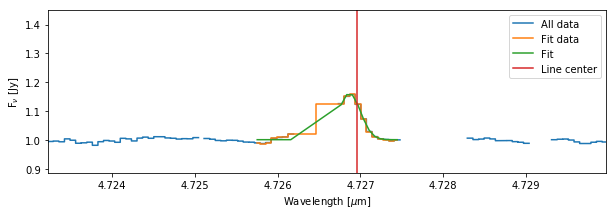

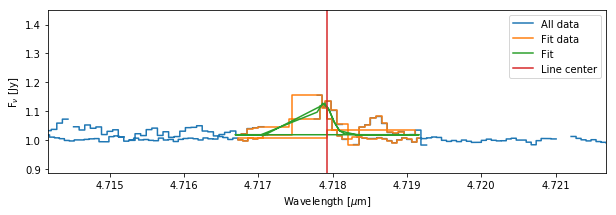

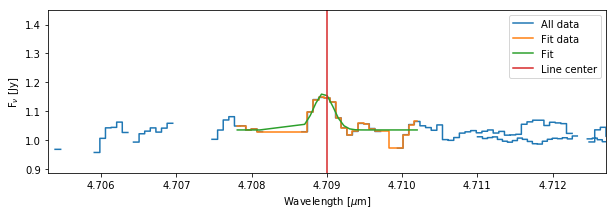

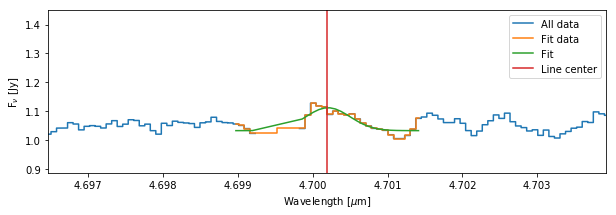

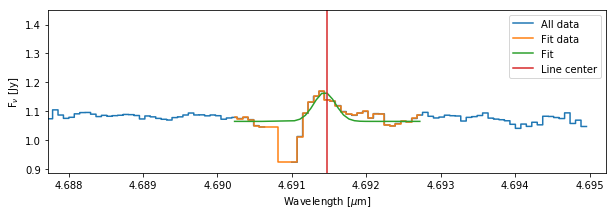

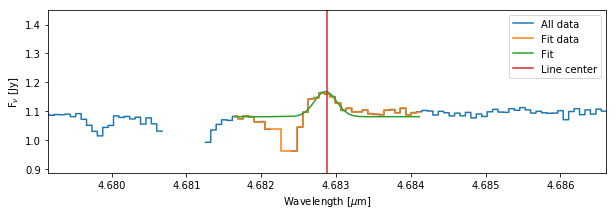

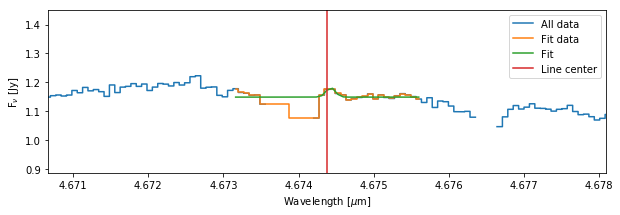

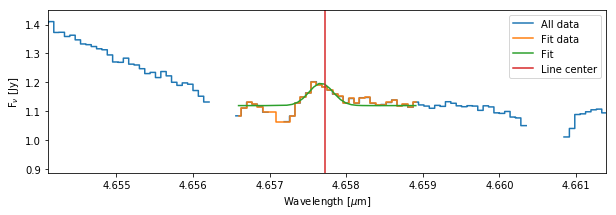

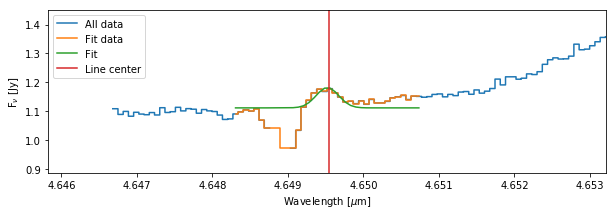

Not enough data near  4.641474250037329  microns. Skipping.
Not enough data near  4.633508286755587  microns. Skipping.
Not enough data near  4.625646279175457  microns. Skipping.
Not enough data near  4.617886796713888  microns. Skipping.
Not enough data near  4.610229362509864  microns. Skipping.
Not enough data near  4.602673976563386  microns. Skipping.


In [67]:
#Read in HITRAN data
out_all=extract_hitran_data('CO',4.6,5.2)  #astropy table
lineflux_data=extract_vup(out_all,1)

#For Data201212310103
wave=df1231['wave']
flux=df1231['div']
out=calc_fluxes(wave,flux,lineflux_data,fwhm_v=17., sep_v=80., cont=1.12,vet_fits=False, plot=True, v_dop=15.)

rot1231=make_rotation_diagram(out)

Not enough data near  5.18900606925888  microns. Skipping.
Not enough data near  5.174782735717755  microns. Skipping.
Not enough data near  5.160712474562946  microns. Skipping.
Not enough data near  5.146793855211405  microns. Skipping.
Not enough data near  5.133025447080083  microns. Skipping.
Not enough data near  5.11940581958593  microns. Skipping.
Not enough data near  5.105934019006913  microns. Skipping.
Not enough data near  5.092607661037948  microns. Skipping.
Not enough data near  5.079426268818019  microns. Skipping.
Not enough data near  5.0663879349030605  microns. Skipping.
Not enough data near  5.053492182432055  microns. Skipping.
Not enough data near  5.04073662709992  microns. Skipping.
Not enough data near  5.028120792045639  microns. Skipping.
Error - curve_fit failed


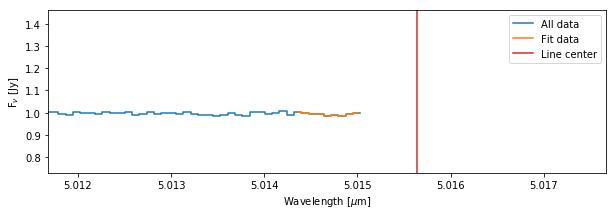

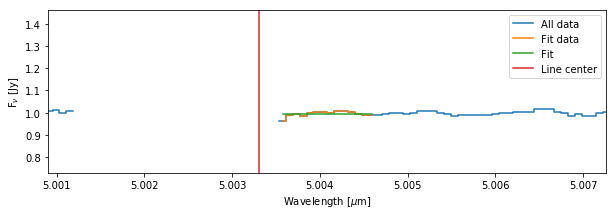

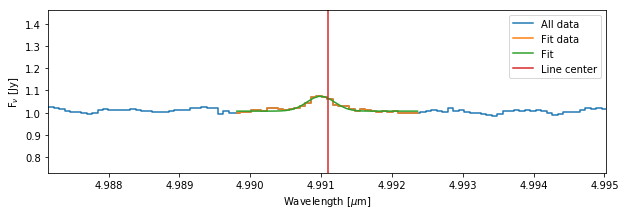

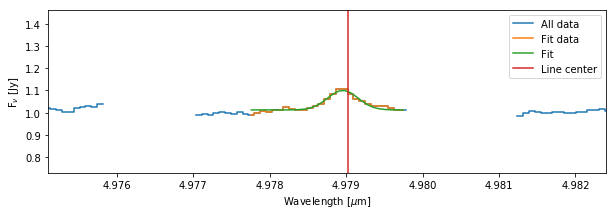

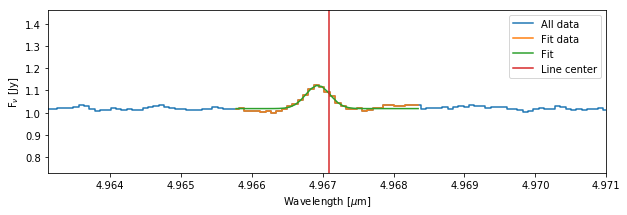

Not enough data near  4.955284086653252  microns. Skipping.
Not enough data near  4.94361005210669  microns. Skipping.
Not enough data near  4.93206620061765  microns. Skipping.
Not enough data near  4.9206515784641  microns. Skipping.
Not enough data near  4.90936475506299  microns. Skipping.
Not enough data near  4.898204776692286  microns. Skipping.
Not enough data near  4.887170689629956  microns. Skipping.
Not enough data near  4.87626106329295  microns. Skipping.
Not enough data near  4.865475420820251  microns. Skipping.
Not enough data near  4.854812808489826  microns. Skipping.
Not enough data near  4.844271795718625  microns. Skipping.
Not enough data near  4.833852382506649  microns. Skipping.
Not enough data near  4.823552184548815  microns. Skipping.
Not enough data near  4.8133716787061385  microns. Skipping.
Not enough data near  4.803309434395571  microns. Skipping.
Not enough data near  4.793363544173045  microns. Skipping.
Not enough data near  4.783535438621612  micr

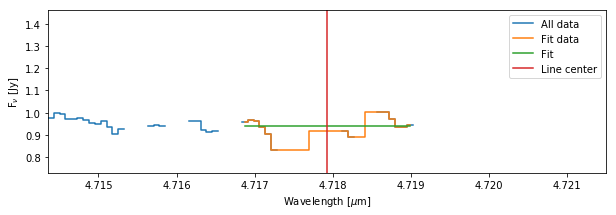

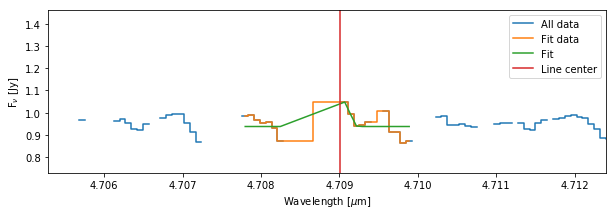

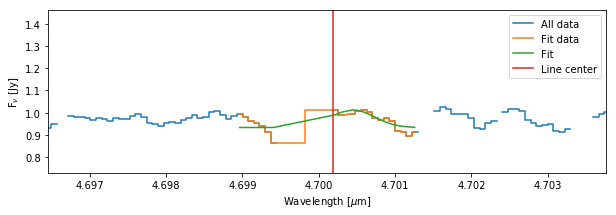

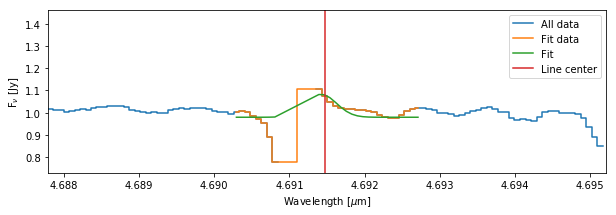

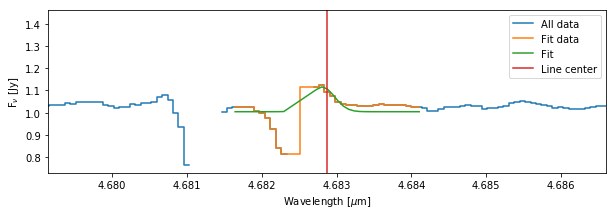

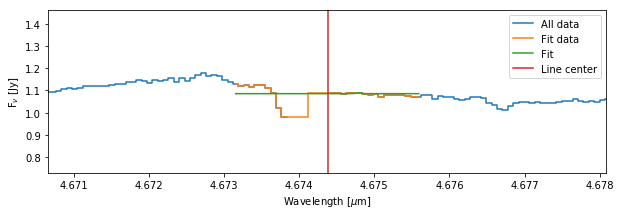

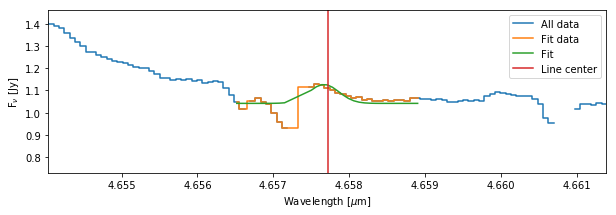

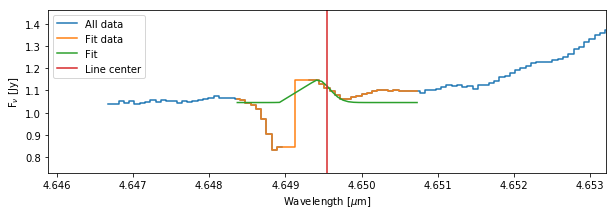

Not enough data near  4.641474250037329  microns. Skipping.
Not enough data near  4.633508286755587  microns. Skipping.
Not enough data near  4.625646279175457  microns. Skipping.
Not enough data near  4.617886796713888  microns. Skipping.
Not enough data near  4.610229362509864  microns. Skipping.
Not enough data near  4.602673976563386  microns. Skipping.


In [13]:
#Read in HITRAN data
out_all=extract_hitran_data('CO',4.6,5.2)  #astropy table
lineflux_data=extract_vup(out_all,1)

#For Data2013122324
wave=df1223['wave']
flux=df1223['div']
out=calc_fluxes(wave,flux,lineflux_data,fwhm_v=17., sep_v=80., cont=1.12,vet_fits=False, plot=True, v_dop=15.)

rot1223=make_rotation_diagram(out)

**Rotation Diagram**

F = A*$\sigma$*$\sqrt{2\pi}$*$\frac{c}{\lambda^2}$      Just use flux calc - how to fix for data['flux']

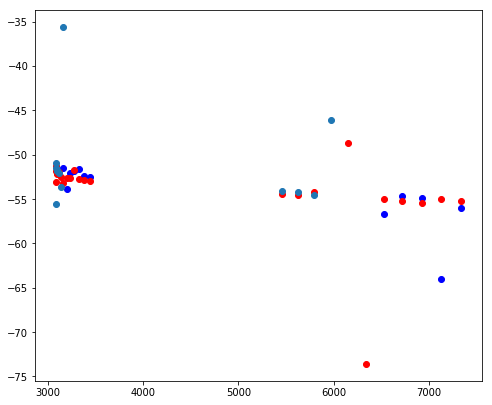

In [14]:
fig =plt.figure(figsize(8,15))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)


plt.plot()
ax1.plot(rot1213['x'],rot1213['y'],'bo')
ax2.plot(rot1231['x'],rot1231['y'],'ro')
ax3.plot(rot1223['x'],rot1223['y'],'o')